In [1]:
######################
# Shout Offset Testing
######################

In [2]:
## Import Libraries

import json
import math
import numpy as np
from scipy import signal
import h5py
import matplotlib.pyplot as plt
from matplotlib import rc
import datetime
import scipy.signal as signal
rc('xtick', labelsize=14) 
rc('ytick', labelsize=14)

In [3]:
## Load recorded data into the environment

def get_time_string(timestamp):
    '''
    Helper function to get data and time from timestamp
    INPUT: timestamp
    OUTPUT: data and time. Example: 01-04-2023, 19:50:27
    '''
    date_time = datetime.datetime.fromtimestamp(int(timestamp))
    return date_time.strftime("%m-%d-%Y, %H:%M:%S")

def JsonLoad(folder, json_file):
    '''
    Load parameters from the saved json file
    INPUT
    ----
        folder: path to the measurement folder. Example: "SHOUT/Results/Shout_meas_01-04-2023_18-50-26"
        json_file: the json file with all the specifications. Example: '/save_iq_w_tx_gold.json'
    OUTPUT
    ----
        samps_per_chip: samples per chip
        wotxrepeat: number of repeating IQ sample collection w/o transmission. Used as an input to 
        traverse_dataset() func
        rxrate: sampling rate at the receiver side
    '''
    config_file = folder+'/'+json_file
    config_dict = json.load(open(config_file))[0]
    nsamps = config_dict['nsamps']
    rxrate = config_dict['rxrate']
    rxfreq = config_dict['rxfreq']
    wotxrepeat = config_dict['wotxrepeat']
    rxrepeat = config_dict['rxrepeat']
    txnodes = config_dict['txclients']
    rxnodes = config_dict['rxclients']

    return rxrepeat, rxrate, txnodes, rxnodes

def traverse_dataset(meas_folder):
    '''
    Load data from hdf5 format measurement file
    INPUT
    ----
        meas_folder: path to the measurement folder. Example: "SHOUT/Results/Shout_meas_01-04-2023_18-50-26"
    OUTPUT
    ----
        data: Collected IQ samples w/ transmission. It is indexed by the transmitter name
        noise: Collected IQ samples w/o transmission. It is indexed by the transmitter name
        txrxloc: transmitter and receiver names
    '''
    data = {}
    noise = {}
    txrxloc = {}

    dataset = h5py.File(meas_folder + '/measurements.hdf5', "r") #meas_folder
    print("Dataset meta data:", list(dataset.attrs.items()))
    for cmd in dataset.keys():
        print("Command:", cmd)
        if cmd == 'saveiq':
            cmd_time = list(dataset[cmd].keys())[0]
            print("  Timestamp:", get_time_string(cmd_time))
            print("  Command meta data:", list(dataset[cmd][cmd_time].attrs.items()))
            for rx_gain in dataset[cmd][cmd_time].keys():
                print("   RX gain:", rx_gain)
                for rx in dataset[cmd][cmd_time][rx_gain].keys():
                    print("     RX:", rx)
                    print("       Measurement items:", list(dataset[cmd][cmd_time][rx_gain][rx].keys()))
        elif cmd == 'saveiq_w_tx':
            cmd_time = list(dataset[cmd].keys())[0]
            print("  Timestamp:", get_time_string(cmd_time))
            print("  Command meta data:", list(dataset[cmd][cmd_time].attrs.items()))
            for tx in dataset[cmd][cmd_time].keys():
                print("   TX:", tx)
                
                if tx == 'wo_tx':
                    for rx_gain in dataset[cmd][cmd_time][tx].keys():
                        print("       RX gain:", rx_gain)
                        #print(dataset[cmd][cmd_time][tx][rx_gain].keys())
                        for rx in dataset[cmd][cmd_time][tx][rx_gain].keys():
                            print("         RX:", rx)
                            #print("           Measurement items:", list(dataset[cmd][cmd_time][tx][rx_gain][rx].keys()))
                            repeat = np.shape(dataset[cmd][cmd_time][tx][rx_gain][rx]['rxsamples'])[0]
                            print("         repeat", repeat)

                            samplesNotx =  dataset[cmd][cmd_time][tx][rx_gain][rx]['rxsamples'][:repeat, :]
                            namelist = rx.split('-')
                            noise[namelist[1]] = samplesNotx
                else:
                    for tx_gain in dataset[cmd][cmd_time][tx].keys():
                        print("     TX gain:", tx_gain)
                        for rx_gain in dataset[cmd][cmd_time][tx][tx_gain].keys():
                            print("       RX gain:", rx_gain)
                            #print(dataset[cmd][cmd_time][tx][tx_gain][rx_gain].keys())
                            for rx in dataset[cmd][cmd_time][tx][tx_gain][rx_gain].keys():
                                repeat = np.shape(dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxsamples'])[0]
                                print("         RX:", rx, "; samples shape", np.shape(dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxsamples']))
                                #print("         Measurement items:", list(dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx].keys()))
                                # print("         rxloc", (dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxloc'][0]))
                                # peak avg check
                                txrxloc.setdefault(tx, []).extend([rx]*repeat)
                                rxsamples = dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxsamples'][:repeat, :]
                                data.setdefault(tx, []).append(np.array(rxsamples))

        else:                       
            print('Unsupported command: ', cmd)

    return data, noise, txrxloc

def plotOnePSDForEachLink(rx_data, txrxloc, samp_rate=250000, repeats=4):
    for txname in rx_data:
        print(txname)
        for i in range(0, len(rx_data[txname]), repeats):
            plt.figure()
            plt.psd(rx_data[txname][i][0], Fs = samp_rate/1000)
            plt.ylim(-110, -60)
            plt.yticks(ticks=[-110, -100, -90, -80, -70, -60])
            plt.grid('on')
            plt.title('TX: {} RX: {}'.format(txname, txrxloc[txname][i]))
            plt.xlabel('Frequency (kHz)')
            plt.tight_layout()
            plt.show()

In [4]:
# Load parameters from the JSON file which describe what was measured
folder = "Shout_meas_02-15-2023_02-43-34"
jsonfile = 'save_iq_w_tx_file.json'
rxrepeat, samp_rate, txlocs, rxlocs = JsonLoad(folder, jsonfile)
# Load data from the HDF5 file, save IQ sample arrays
rx_data, _, txrxloc = traverse_dataset(folder)
samp_rate = 250000.0
print(txlocs)

Dataset meta data: [('shout_version', '5bd42c5')]
Command: saveiq_w_tx
  Timestamp: 02-15-2023, 03:43:36
  Command meta data: [('cmd', 'save_iq_w_tx'), ('nsamps', 8192), ('rxfreq', 3455000000.0), ('rxgain', 30.0), ('rxrate', 250000.0), ('rxrepeat', 4), ('rxwait_max', 2000), ('rxwait_min', 50), ('rxwait_random', True), ('rxwait_res', 'ms'), ('start_time', 1676454222.0), ('sync', True), ('timeout', 30), ('timezone', 'US/Mountain'), ('txfile', '/local/repository/shout/signal_library/QPSK_signal_2023_01_18_neal.iq'), ('txfreq', 3455000000.0), ('txgain', 27.0), ('txrate', 250000.0), ('txwait', 3), ('use_lo_offset', True), ('wotxrepeat', 0)]
   TX: cbrssdr1-bes-comp
     TX gain: 27.0
       RX gain: 30.0
         RX: cbrssdr1-browning-comp ; samples shape (4, 8192)
         RX: cbrssdr1-fm-comp ; samples shape (4, 8192)
         RX: cbrssdr1-honors-comp ; samples shape (4, 8192)
         RX: cbrssdr1-hospital-comp ; samples shape (4, 8192)
         RX: cbrssdr1-smt-comp ; samples shape (4, 

250000.0
cbrssdr1-bes-comp


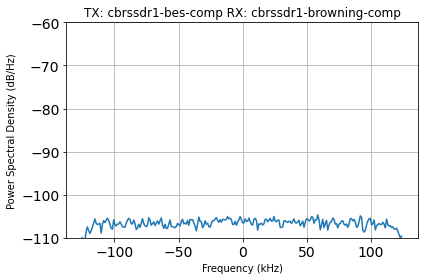

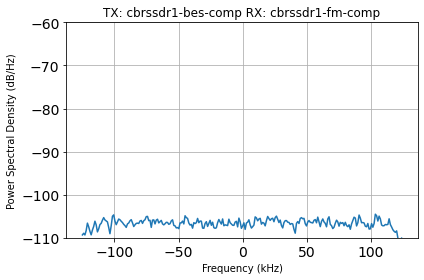

cbrssdr1-browning-comp


/Users/cassiejeng/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7184: RuntimeWarning: divide by zero encountered in log10
  line = self.plot(freqs, 10 * np.log10(pxx), **kwargs)


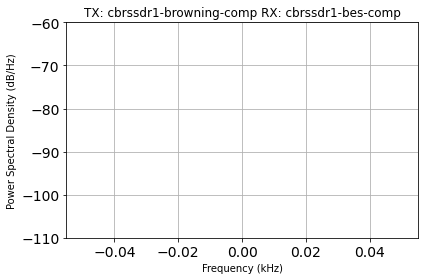

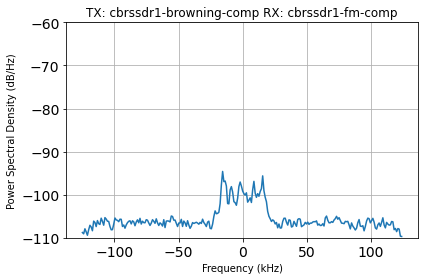

cbrssdr1-fm-comp


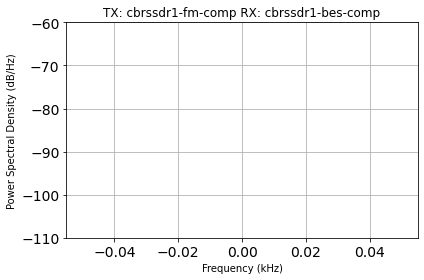

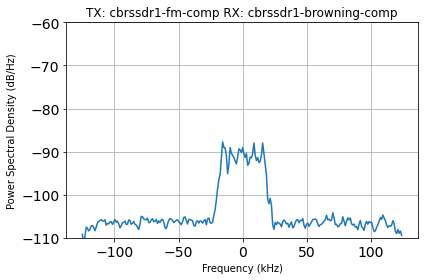

cbrssdr1-honors-comp


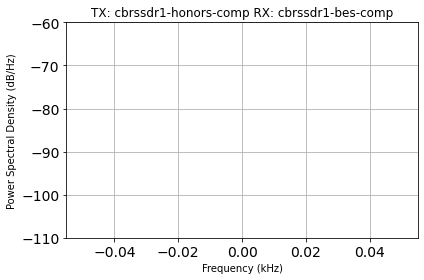

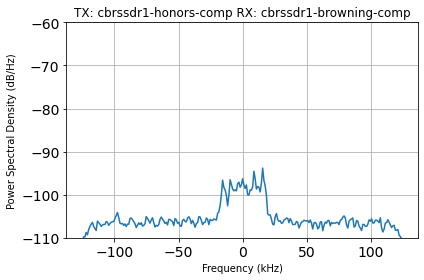

cbrssdr1-hospital-comp


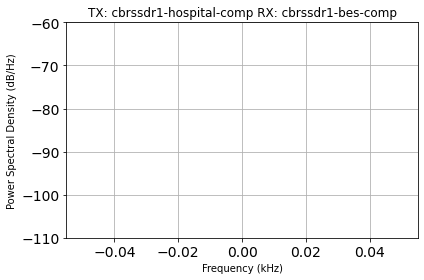

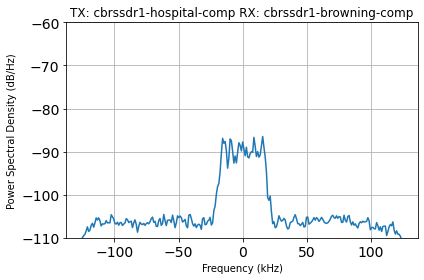

cbrssdr1-smt-comp


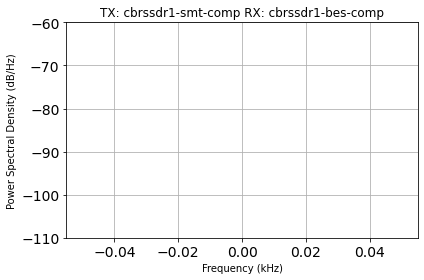

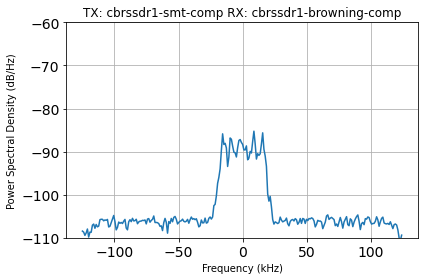

cbrssdr1-ustar-comp


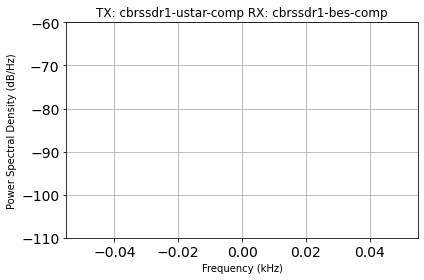

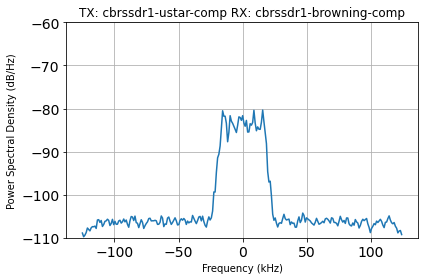

In [5]:
# plot all links
print(samp_rate)
plotOnePSDForEachLink(rx_data, txrxloc, samp_rate)

In [6]:
## Pick Transmitter / Receiver Pair

# Pick one received signal to demodulate
txloc = 'cbrssdr1-smt-comp'
rxloc = 'cbrssdr1-hospital-comp'
repNum = 0

rx_data[txloc] = np.vstack(rx_data[txloc])
rxloc_arr = np.array(txrxloc[txloc])
rx0 = rx_data[txloc][rxloc_arr==rxloc][repNum]
print('\nLink: {} to {}. Repetition Num {}.'.format(txloc, rxloc, repNum))
rx0.shape


Link: cbrssdr1-smt-comp to cbrssdr1-hospital-comp. Repetition Num 0.


(8192,)

<Figure size 432x288 with 0 Axes>

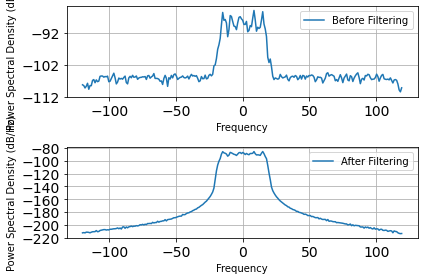

In [7]:
## Low Pass Filtering to out_of_band frequency components

# Design parameters
stopband_attenuation = 60.0
transition_bandwidth = 0.05
cutoff_norm = 0.15
# What order filter do we need?
filterN, beta = signal.kaiserord(stopband_attenuation, transition_bandwidth)
# Create the filter coefficients
taps = signal.firwin(filterN, cutoff_norm, window=('kaiser', beta))
# Use the filter on the received signal
filtered_rx0 = signal.lfilter(taps, 1.0, rx0)

# Plot psd of received signal before and after filtering
plt.figure()
fig, subfigs = plt.subplots(2,1)
subfigs[0].psd(rx0, Fs = 240, label='Before Filtering')
subfigs[0].legend()
subfigs[1].psd(filtered_rx0, Fs = 240, label='After Filtering')
subfigs[1].legend()
plt.tight_layout()
plt.show()

In [8]:
## Preamble synchronization
# Quiet + Preamble + Sync + Data

# PURPOSE: convert input data stream to signal space values for
#          a particular modulation type (as specified by the inputVec
#          and outputVec).
# INPUT: data (groups of bits)
# OUTPUT: signal space values
def lut(data, inputVec, outputVec):
    if len(inputVec) != len(outputVec):
        print('Input and Output vectors must have identical length')
    # Initialize output
    output = np.zeros(data.shape)
    # For each possible data value
    eps = np.finfo('float').eps
    for i in range(len(inputVec)):
        # Find the indices where data is equal to that input value
        for k in range(len(data)):
            if abs(data[k]-inputVec[i]) < eps:
                # Set those indices in the output to be the appropriate output value.
                output[k] = outputVec[i]
    return output

# PURPOSE: insert 0's between samples to oversample at OS_Rate
# INPUT: x (data), OS_Rate (how frequently data occurs)
# OUTPUT: x_s (oversampled data)
def oversample(x, OS_Rate):
    # Initialize output
    x_s = np.zeros(len(x)*OS_Rate)
    x_s[::OS_Rate] = x
    return x_s

# PURPOSE: create a square root raised cosine pulse shape
# INPUT: alpha, N, Lp
# OUTPUT: pulse wave array for srrc
def SRRC(alpha, N, Lp):
    # Add epsilon to the n values to avoid numerical problems
    n = np.arange(-N*Lp+ (1e-9), N*Lp+1)
    h = np.zeros(len(n))
    coeff = 1/np.sqrt(N)
    for i, each in enumerate(n):
        sine_term = np.sin(np.pi * each * (1-alpha) / N)
        cosine_term = np.cos(np.pi * each * (1+alpha) / N)
        cosine_coeff = 4 * alpha * each / N
        numerator = sine_term + (cosine_coeff * cosine_term)
        denom_coeff = np.pi * each / N
        denom_part = 1 - cosine_coeff**2
        denominator = denom_coeff * denom_part
        h[i] = coeff * numerator / denominator
    return h

# PURPOSE: Convert binary data to M-ary by making groups of log2(M)
#          bits and converting each bit to one M-ary digit.
# INPUT: Binary digit vector, with length as a multiple of log2(M)
# OUTPUT: M-ary digit vector
def binary2mary(data, M):

    log2M   = round(np.log2(M))
    # integer number of bits per group
    if (len(data) % log2M) != 0:
        print('Input to binary2mary must be divisible by log2(m).')
    data.shape = (len(data)//log2M, log2M)
    binaryValuesArray = 2**np.arange(log2M)
    marydata = data.dot(binaryValuesArray)
    return marydata

# PURPOSE: create a modulated signal with the defined preamble
# INPUT: A (sqrt value for modulation), N, alpha, Lp (for srrc)
# OUTPUT: modulated preamble signal & srrc pulse
def createPreambleSignal(A, N, alpha, Lp):

    # We defined the preamble as this repeating bit signal:
    preamble     = np.tile([1, 1, 0, 0], 16)

    ###########################################
    ### Signal Generation
    ### INPUT: binary data
    ### OUTPUT: 4-ary data (0..3) values
    data = binary2mary(preamble, 4)

    ###########################################
    ### Modulation
    ### INPUT: data
    ### OUTPUT: modulated values, x
    inputVec   = [0, 1, 2, 3]
    outputVecI = [A, -A, A, -A]
    outputVecQ = [A, A, -A, -A]
    xI         = lut(data, inputVec, outputVecI)
    xQ         = lut(data, inputVec, outputVecQ)

    ###########################################
    ### Upsample
    ### INPUT: modulated values, x
    ### OUTPUT: modulated values at sampling rate, x_s
    x_s_I = oversample(xI, N)
    x_s_Q = oversample(xQ, N)

    ###########################################
    ### Pulse-shape filter
    ### INPUT: modulated values at sampling rate, x_s
    ### OUTPUT: baseband transmit signal s
    pulse = SRRC(alpha, N, Lp)
    s_0_I = np.convolve(x_s_I, pulse, mode='full')
    s_0_Q = np.convolve(x_s_Q, pulse, mode='full')
    
    return (s_0_I + 1j*s_0_Q), pulse

In [9]:
# PURPOSE: perform preamble synchronization
#          Uses the (complex-valued) preamble signal. The cross-correlation 
#          of the preamble signal and the received signal (at the time
#          when the preamble is received) should have highest magnitude
#          at the index delay where the preamble approximately starts.  
# INPUT:   rx0: received signal (with a frequency offset)
#          preambleSignal: complex, known, transmitted preamble signal 
# OUTPUT:  lagIndex: the index of rx0 where the preamble signal has highest 
#              cross-correlation
#
def crossCorrelationMax(rx0, preambleSignal):

    # Cross correlate with the preamble to find it in the noisy signal
    lags      = signal.correlation_lags(len(rx0), len(preambleSignal), mode='same')
    xcorr_out = signal.correlate(rx0, preambleSignal, mode='same')
    xcorr_mag = np.abs(xcorr_out)
    # There may be two preambles because the packet repeats, and the number
    # of recorded samples is much longer than the length of a single packet.
    # Here we give the length of the packet, and we don't look for a preamble
    # that starts at the very end of the packet (so that we don't run out of
    # samples while demodulating the packet.)
    length_of_packet = 3200
    maxIndex = np.argmax(xcorr_mag[:len(xcorr_mag)-length_of_packet])
    lagIndex = lags[maxIndex]

    print('Max crosscorrelation with preamble at lag ' + str(lagIndex))

    # Plot the selected signal.
    plt.figure()
    fig, subfigs = plt.subplots(2,1)
    short_t = range(lagIndex, lagIndex + len(preambleSignal))
    subfigs[0].plot(np.real(rx0), label='Real RX')
    subfigs[0].plot(np.imag(rx0), label='Imag RX')
    scale_factor = np.mean(np.abs(rx0))/np.mean(np.abs(preambleSignal))
    subfigs[0].plot(short_t, scale_factor*np.real(preambleSignal), label='Real Preamble')
    subfigs[0].set(ylabel='RX Signal')
    subfigs[0].legend()
    subfigs[1].plot(lags, xcorr_mag, label='|X-Correlation|')
    subfigs[1].legend()
    subfigs[1].set(ylabel='|X-Correlation|')
    plt.xlabel('Sample Index', fontsize=14)
    plt.tight_layout()

    # Plot zoomed in to the place where the preamble signal was detected.
    plt.figure()
    plt.plot(short_t, np.real(rx0[short_t]), label='Real RX Signal')
    plt.plot(short_t, np.imag(rx0[short_t]), label='Imag RX Signal')
    plt.plot(short_t, scale_factor*np.real(preambleSignal), label='Real Preamble')
    plt.ylabel('RX Signal')
    plt.xlabel('Sample Index', fontsize=14)
    plt.legend()

    return lagIndex

Max crosscorrelation with preamble at lag 2967


<Figure size 432x288 with 0 Axes>

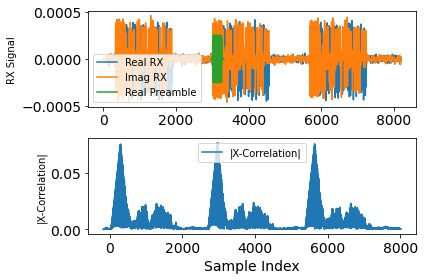

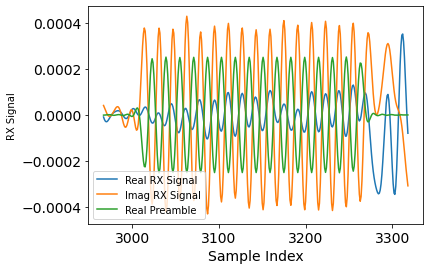

In [10]:
A = np.sqrt(9/2)
N = 8
alpha = 0.5
Lp = 6
preambleSignal, pulse = createPreambleSignal(A, N, alpha, Lp)
lagIndex = crossCorrelationMax(filtered_rx0, preambleSignal)

In [11]:
## Estimation and Correction of Frequency Offset

# PURPOSE: perform frequency offset estimation and correction.
#          Uses the (complex-valued) preamble signal. The product of 
#          the preamble signal and the received signal (at the time
#          when the preamble is received) has a frequency component near
#          zero at the frequency offset.  Find it from the max of the DFT.
#          We need a very fine resolution on that frequency, so we don't
#          use the FFT, we calculate it from the DFT definition.
# INPUT:   rx0: received signal (with a frequency offset)
#          preambleSignal: complex, known, transmitted preamble signal 
#          lagIndex: the index of rx0 where the preamble signal has highest 
#              cross-correlation
# OUTPUT:  rx1: Frequency-corrected received signal
#          frequencyOffset
#
def estimateFrequencyOffset(rx0, preambleSignal, lagIndex,debug=False):

    # Estimate a frequency offset using the known preamble signal
    if len(preambleSignal) < 200:
        print("estimateFrequencyOffset: Error in Preamble Signal Length")

    # if you don't discard the start and end of the preamble signal, it
    # can overlap with the synch word at its tail end, and this will
    # cause some errors in the frequency estimate.
    discardSamples = 60
    middle_of_preamble = preambleSignal[discardSamples:-discardSamples]
    N        = len(middle_of_preamble)
    # taking the max of 0 and lagIndex+discardSamples for start >=0 rx0 index
    startInd = max(0, lagIndex+discardSamples)
    rx0_part = np.conjugate(rx0[startInd:(startInd + N)])
    prod_rx0_preamble = rx0_part*middle_of_preamble

    # Frequencies at which freq content is calc'ed.
    # We'll multiply the generated matrix by the data to calculate PSD
    # frequencies are normalized to sampling rate
    # MUST BE SET BY USER.  For POWDER with frequency synched nodes, we
    # expect at most 200e-9 frequency offset, which at center frequency of 3.5 GHz
    # and 240k sample rate, is 3.5e9 * 200e-9 / 240e3 = 0.003.  But we can
    # be conservative and make it larger, no problem.  We want to get the offset
    # down to at most 5 Hz b/c the packet duration is about 20 ms, so that would
    # keep the drift to about 1/10 of a rotation over the whole packet.
    maxFreqOffset   = 0.010000
    deltaFreqOffset = 0.000005
    freqRange    = np.arange(-maxFreqOffset, maxFreqOffset, deltaFreqOffset)
    temp         = (-1j*2*np.pi) * freqRange
    expMat       = np.transpose(np.array([np.exp(temp*i) for i in np.arange(0,N)]))
    # print('expMat.size',expMat.size)
    # print('N',N)
    # print('len(prod_rx0_preamble)',len(prod_rx0_preamble))
    PSD_prod     = np.abs(expMat.dot(prod_rx0_preamble))**2

    #if debug:
    plt.figure()
    plt.plot(250000.0*freqRange,PSD_prod,'r.')
    plt.grid('on')
    plt.xlabel('Frequency Offset')
    plt.ylabel('sqrt PSD')
    # plt.show()

    maxIndexPSD  = np.argmax(PSD_prod)
    maxIndexFreq = freqRange[maxIndexPSD]
    print('[estimateFrequencyOffset] Frequency offset estimate: ' + str(maxIndexFreq*samp_rate) + ' Hz')

    return maxIndexFreq


# PURPOSE: perform frequency offset correction.
# INPUT:   rx0: received signal (with a frequency offset)
#          maxIndexFreq: The frequency offset estimate
# OUTPUT:  rx1: Frequency-corrected received signal
#
def correctFrequencyOffset(rx0, maxIndexFreq):

    # Do frequency correction on the input signal
    expTerm = np.exp((1j*2*np.pi * maxIndexFreq) * np.arange(len(rx0)))
    rx1 = expTerm * rx0
    return rx1

[estimateFrequencyOffset] Frequency offset estimate: 19.99999999989727 Hz


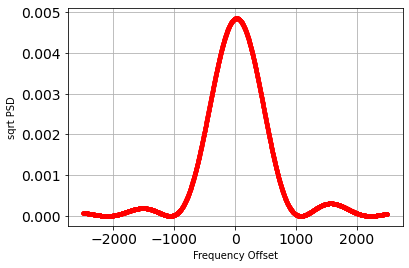

In [12]:
freqOffsetEst = estimateFrequencyOffset(filtered_rx0, preambleSignal, lagIndex)

In [13]:
# Now perform frequency correction, if so desired.
# If the signal has low SNR, this frequency offset estimation method isn't great, 
# so you might want to skip the correctFrequencyOffset command.  You can do that
# by setting rx1 = rx0.
rx1 = correctFrequencyOffset(filtered_rx0, 0)   # Don't do frequency correction.
#rx1 = correctFrequencyOffset(filtered_rx0, freqOffsetEst). # Do frequency correction.

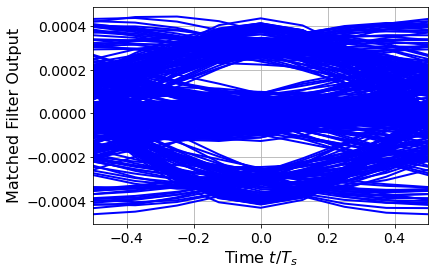

In [14]:
## Phase synchronization

# PURPOSE: Plot an eye diagram of a signal
# INPUT: y_s: vector of signal samples out of the matched filter
#        N: the number of samples per symbol. Assumes that time 0 is at sample
#        y_s[0]. If not, you must send in an offset integer.
# OUTPUT: none
def plot_eye_diagram(y_s, N, offset=0):
    start_indices = range(int(np.floor(N/2.0)) + offset - 1, len(y_s) - N, N)
    time_vals     = np.arange(-0.5, 0.5+1.0/N, 1.0/N)

    plt.figure()
    for i, start_i in enumerate(start_indices):
        plt.plot(time_vals, y_s[start_i:(start_i+N+1)], 'b-', linewidth=2)
        
    plt.xlabel(r'Time $t/T_s$', fontsize=16)
    plt.xlim([-0.5, 0.5])
    plt.ylabel('Matched Filter Output', fontsize=16)
    plt.grid(True)
    plt.show()

# Plot the matched filter output in an eye diagram (looking at each symbol period)
preambleStart = lagIndex + Lp*N*2 + N + 1  # There's also the delay b/c the SRRC pulse is this long.
plot_eye_diagram(np.imag(rx1), N, offset=preambleStart)

In [15]:
# PURPOSE: Plot the signal symbol samples on a complex plane
# INPUT:   Received complex values (output of matched filter downsampled)
# OUTPUT:  none
def constellation_plot(rx4):
    # I like a square plot for the constellation so that both dimensions look equal
    plt.figure(figsize=(5,5))
    ax = plt.gca() 
    ax.set_aspect(1.0) # Make it a square 1x1 ratio plot
    plt.plot(np.real(rx4), np.imag(rx4),'ro')
    plt.ylabel('Imag(Symbol Sample)', fontsize=14)
    plt.xlabel('Real(Symbol Sample)', fontsize=14)
    plt.grid('on')
    plt.tight_layout()

In [16]:
# The every even (0, 2, ...) preamble symbol, should be at an angle of pi/4.
# Average a few of the first symbol values, find the angle of that average
average_even_preamble_symbol = np.mean(rx1[preambleStart:preambleStart+128:(2*N)])
correction_angle = np.pi/4 - np.angle(average_even_preamble_symbol)
print("Turn signal by correction angle of: %f degrees" % (correction_angle*180/np.pi))
rx2 = rx1 * np.exp(1j*correction_angle)
print("New angle of first preamble symbol: %f degrees" % (np.angle(rx2[preambleStart], deg=True)))

Turn signal by correction angle of: 144.084268 degrees
New angle of first preamble symbol: 48.966399 degrees


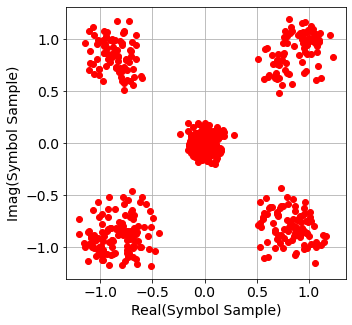

In [17]:
###########################################
# Downsample
# INPUT: Synched matched filter output
# OUTPUT: Symbol Samples (at n*T_sy)
rx3 = rx2[preambleStart::N]
rx3 = rx3 / np.median(np.abs(rx3))  # "AGC" to make symbol values close to +/- 1

# Ignore initial samples that are very close to the origin, compared to later samples.
startsymbol = np.where(np.abs(rx3)>0.2)[0][0]
rx4 = rx3[startsymbol:]
constellation_plot(rx4)

In [18]:
## Symbol Detection

# PURPOSE: Find the symbols which are closest in the complex plane 
#          to the measured complex received signal values.
# INPUT:   Received r_hat values (output of matched filter downsampled),
#          and possible signal space complex values. 
# OUTPUT:  m-ary symbol indices in 0...length(outputVec)-1
def findClosestComplex(r_hat, outputVec):
    # outputVec is a 4-length vector for QPSK, would be M for M-QAM or M-PSK.
    # This checks, one symbol sample at a time,  which complex symbol value
    # is closest in the complex plane.
    data_out = [np.argmin(np.abs(r-outputVec)) for r in r_hat]
    return data_out

# Purpose: Convert M-ary data to binary data
#          each m-ary value input in "data" is converted to
#          log2(M) binary values.
# INPUT: M-ary digit vector
# OUTPUT: Binary digit vector, with length equal to the number
#         of values in data multiplied by log2(M)
def mary2binary(data, M):
    length = len(data) # number of values in data
    log2M = round(np.log2(M)) # integer number of bits per data value
    format_string = '0' + str(log2M) + 'b'
    binarydata = np.zeros((1,length*log2M))
    count = 0
    for each in data:
        binval = format(int(each), format_string)
        for i in range(log2M):
            binarydata[0][count+i] = int(binval[i])
        count = count + log2M
    return binarydata

###########################################
# Symbol Decisions
# INPUT: Symbol Samples
# OUTPUT: Bits
outputVec = np.array([1+1j, -1+1j, 1-1j, -1-1j])
mary_out  = findClosestComplex(rx4, outputVec)
binary_out = mary2binary(mary_out,4)[0]
print('The Decoded data bits are: mary_out[0:10]',binary_out)

The Decoded data bits are: mary_out[0:10] [0. 0. 1. ... 0. 1. 0.]


In [19]:
## Message extraction

# Find the sync word in the vector of all bit decisions, and flip all bits if 
# The synch word is negated.
def phaseSyncAndExtractMessage(bits_out, syncWord, numDataBits):

    # The preamble is 64 bits, the sync word is 16 bits.  So it should be in the first
    # 100 or so bits.  If you search all bits, you may find some bit string close enough
    # to the sync word by chance in the data bits, so dont search all bit decisions.
    maxToSearch = 120 
    lagsSynch   = signal.correlation_lags(maxToSearch, len(syncWord))
    # The "2*x-1" converts from a (0,1) bit to a (-1,1) representation
    temp        = signal.correlate(2*bits_out[:maxToSearch]-1, 2*syncWord-1)
    maxIndexSync = np.argmax(np.abs(temp))
    maxSync     = temp[maxIndexSync]
    # In case phase synchronization didn't work, a 180 degree phase error
    # would result in all bits being negated.  Fix that here.
    if maxSync < 0:   
        final_bits_out = 1 - bits_out
    else:
        final_bits_out = bits_out

    dataBitsStartIndex = lagsSynch[maxIndexSync] + len(syncWord)
    if dataBitsStartIndex+numDataBits < len(final_bits_out):
        data_bits = final_bits_out[dataBitsStartIndex:(dataBitsStartIndex+numDataBits)]
    else:
        data_bits = final_bits_out[dataBitsStartIndex:]
        print("Error: The packet extended beyond the end of the sample file.")
    return data_bits

# Convert the data bits to a string, assuming 7 bits per character.
def binvector2str(binvector):
    #binvector = binvector[0]
    length = len(binvector)
    eps = np.finfo('float').eps
    if abs(length/7 - round(length/7)) > eps:
        print('Length of bit stream must be a multiple of 7 to convert to a string.')
    # Each character requires 7 bits in standard ASCII
    num_characters = round(length/7)
    # Maximum value is first in the vector. Otherwise would use 0:1:length-1
    start = 6
    bin_values = []
    while start >= 0:
        bin_values.append(int(math.pow(2,start)))
        start = start - 1
    bin_values = np.array(bin_values)
    bin_values = np.transpose(bin_values)
    str_out = '' # Initialize character vector
    for i in range(num_characters):
        single_char = binvector[i*7:i*7+7]
        value = 0
        for counter in range(len(single_char)):
            value = value + (int(single_char[counter]) * int(bin_values[counter]))
        str_out += chr(int(value))
    return str_out

In [20]:
###########################################
# Sync Word Discovery and Data Bits Extraction
# INPUT: Bit estimates from the received signal. 
#        Must have sync word used at the transmitter.
# OUTPUT: Bits from the data (the actual message)
syncWord    = np.array([1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0])
dataBitLength = 658

# Find the sync word in the vector of all bit decisions, and flip all bits if 
# The synch word is negated.
data_bits   = phaseSyncAndExtractMessage(binary_out, syncWord, dataBitLength)
extract_message = binvector2str(data_bits)

###########################################################################
print('The Extracted Message Output is:\n',extract_message)

The Extracted Message Output is:
 I attend Washington University in St. Louis.1DGD!f~"("48!A9A6GG8NdvS9c3/	v[f3Lf3Lf:
